# Lets make an interactive web application from scratch

First we have to import some dependencies 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')
import urbanpy as up
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
tqdm.pandas()

## Downloading urban data

This notebook is going to use the Lima's metropolitan area as an example. now we are going to download Lima province & Callao province limits and merge them to obtain Lima's Metropolitan area.

In [4]:
manta = up.download.nominatim_osm('Manta, Ecuador')

<AxesSubplot:>

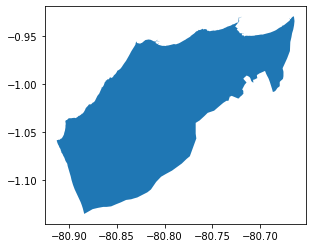

In [5]:
manta.plot()

It is useful to have a uniform spatial unit in order to apply algorithms and visualize differents cities data. UrbanPy lets your easily leverage all the power of Uber H3 package to partition the city in uniform hexagons.

In [6]:
hex_manta = up.geom.gen_hexagons(resolution=9, city=manta)

In [7]:
hex_manta.head()

,hex,geometry
0,898f2e05eabffff,"POLYGON ((-80.67731 -0.95659, -80.67846 -0.958..."
1,898f2e05e8bffff,"POLYGON ((-80.68244 -0.94926, -80.68359 -0.950..."
2,898f2e72803ffff,"POLYGON ((-80.87864 -1.04012, -80.87979 -1.041..."
3,898f2e72d6bffff,"POLYGON ((-80.86384 -1.04011, -80.86499 -1.041..."
4,898f2e0ccafffff,"POLYGON ((-80.74222 -1.01000, -80.74337 -1.011..."


In [8]:
hex_manta.shape

(2416, 2)

<AxesSubplot:>

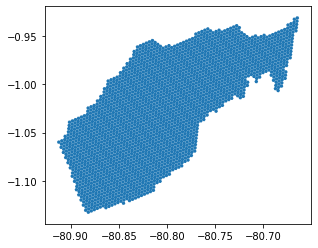

In [9]:
hex_manta.plot()

### Downloading high resolution population data

Using the `download.search_hdx_dataset` and `download.get_hdx_dataset` functions you can download high resolution population data, please be patient this may take a while ...

In [10]:
ecu_resources_df = up.download.search_hdx_dataset('ecuador')
ecu_resources_df

,created,name,population,size_mb,url
id,,,,,
0,2019-06-11,ecu_general_2020_csv.zip,Overall population density,19.29,https://data.humdata.org/dataset/58c3ac3f-febd...
2,2019-06-11,ecu_children_under_five_2020_csv.zip,Children (ages 0-5),19.36,https://data.humdata.org/dataset/58c3ac3f-febd...
4,2019-06-11,ecu_elderly_60_plus_2020_csv.zip,Elderly (ages 60+),19.35,https://data.humdata.org/dataset/58c3ac3f-febd...
6,2019-06-11,ecu_men_2020_csv.zip,Men,19.29,https://data.humdata.org/dataset/58c3ac3f-febd...
8,2019-06-11,ecu_women_2020_csv.zip,Women,19.30,https://data.humdata.org/dataset/58c3ac3f-febd...
10,2019-06-11,ecu_women_of_reproductive_age_15_49_2020_csv.zip,Women of reproductive age (ages 15-49),19.34,https://data.humdata.org/dataset/58c3ac3f-febd...
12,2019-06-11,ecu_youth_15_24_2020_csv.zip,Youth (ages 15-24),19.34,https://data.humdata.org/dataset/58c3ac3f-febd...


In [11]:
ecu_elderly_pop = up.download.get_hdx_dataset(ecu_resources_df, 4)

In [12]:
manta_elderly_pop = up.geom.filter_population(ecu_elderly_pop, manta)

In [13]:
manta_elderly_pop.head()

,longitude,latitude,ecu_elderly_60_plus_2020,geometry
1304444,-80.664167,-0.929722,0.879118,POINT (-80.66417 -0.92972)
1304671,-80.665556,-0.930000,0.879118,POINT (-80.66556 -0.93000)
1304672,-80.664444,-0.930000,0.879118,POINT (-80.66444 -0.93000)
1304673,-80.664167,-0.930000,0.879118,POINT (-80.66417 -0.93000)
1304932,-80.665278,-0.930278,0.879118,POINT (-80.66528 -0.93028)


### Unify data layers

Lets get the population per hexagon

In [14]:
hex_manta_gdf = up.geom.merge_shape_hex(hex_manta, manta_elderly_pop, how='inner', 
    predicate='intersects', agg={'ecu_elderly_60_plus_2020': 'sum'})

In [15]:
hex_manta_gdf.head()

,hex,geometry,ecu_elderly_60_plus_2020
0,898f2e05eabffff,"POLYGON ((-80.67731 -0.95659, -80.67846 -0.958...",70.329442
1,898f2e05e8bffff,"POLYGON ((-80.68244 -0.94926, -80.68359 -0.950...",22.857069
2,898f2e72803ffff,"POLYGON ((-80.87864 -1.04012, -80.87979 -1.041...",NaN
3,898f2e72d6bffff,"POLYGON ((-80.86384 -1.04011, -80.86499 -1.041...",1.313324
4,898f2e0ccafffff,"POLYGON ((-80.74222 -1.01000, -80.74337 -1.011...",NaN


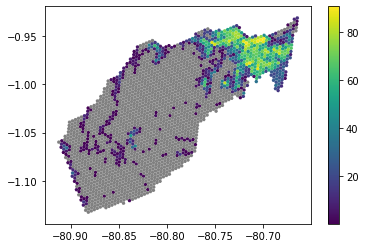

In [16]:
hex_manta_gdf.plot(column='ecu_elderly_60_plus_2020', legend=True, missing_kwds={'color': 'grey'})
plt.show()

**Validation**: The difference between original population total and downscaled population total must be a small number

In [17]:
(manta_elderly_pop['ecu_elderly_60_plus_2020'].sum(), hex_manta_gdf['ecu_elderly_60_plus_2020'].round(0).sum(), 
 manta_elderly_pop['ecu_elderly_60_plus_2020'].sum() - hex_manta_gdf['ecu_elderly_60_plus_2020'].round(0).sum())

(24655.201228082176, 21286.0, 3369.2012280821764)

## Downloading Points of Interest (PoI) data

### Health facilities

In [18]:
health_facilities = up.download.overpass_pois(bounds=manta.total_bounds, facilities='health')

In [19]:
health_facilities.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,367826732,-0.944024,-80.733939,"{'amenity': 'pharmacy', 'brand': 'Fybeca', 'br...",POINT (-80.73394 -0.94402),pharmacy
1,node,367830065,-0.953998,-80.741467,"{'amenity': 'hospital', 'healthcare': 'hospita...",POINT (-80.74147 -0.95400),hospital
2,node,367830072,-0.953488,-80.740739,"{'amenity': 'hospital', 'healthcare': 'hospita...",POINT (-80.74074 -0.95349),hospital
3,node,3206491590,-1.040708,-80.665107,"{'amenity': 'hospital', 'name': 'Clínica Monte...",POINT (-80.66511 -1.04071),hospital
4,node,4122103989,-0.970592,-80.702927,"{'addr:street': 'Avenida 4 de Noviembre', 'ame...",POINT (-80.70293 -0.97059),clinic


In [20]:
health_facilities['poi_type'].value_counts()

pharmacy    40
hospital    11
clinic      11
doctors      3
dentist      1
Name: poi_type, dtype: int64

### Measuring accesibility

#### Accesibility to hospital and clinics

In [21]:
clinics_and_hospitals = health_facilities[health_facilities['poi_type'].isin(['clinic', 'hospital'])]

In [22]:
# start server
up.routing.start_osrm_server('ecuador', 'south-america', 'foot')

Starting server ...
osrm_routing_server_south-america_ecuador_foot
Server was started succesfully


Now we are going to find the route distance and duration using an OSRM local server. To find the nearest food facility to each hexagon this function use a neighborhood search algorithm (lower precision but significant time savings)

In [23]:
hex_manta_gdf_access = up.accessibility.travel_times(hex_manta_gdf, clinics_and_hospitals, 'health_facility')

  0%|          | 0/2416 [00:00<?, ?it/s]

In [24]:
hex_manta_gdf_access.head()

,hex,geometry,ecu_elderly_60_plus_2020,lon,lat,nearest_health_facility_ix,distance_to_nearest_health_facility,duration_to_nearest_health_facility,duration_to_nearest_health_facility_label
0,898f2e05eabffff,"POLYGON ((-80.67731 -0.95659, -80.67846 -0.958...",70.329442,-80.676513,-0.958371,12,1.7087,20.503333,De 15 a 30
1,898f2e05e8bffff,"POLYGON ((-80.68244 -0.94926, -80.68359 -0.950...",22.857069,-80.681642,-0.951038,12,0.6166,7.395000,De 0 a 15
2,898f2e72803ffff,"POLYGON ((-80.87864 -1.04012, -80.87979 -1.041...",NaN,-80.877842,-1.041897,19,8.7704,105.233333,De 90 a 120
3,898f2e72d6bffff,"POLYGON ((-80.86384 -1.04011, -80.86499 -1.041...",1.313324,-80.863041,-1.041887,19,6.0144,72.165000,De 60 a 90
4,898f2e0ccafffff,"POLYGON ((-80.74222 -1.01000, -80.74337 -1.011...",NaN,-80.741422,-1.011778,21,7.1465,85.763333,De 60 a 90


In [25]:
up.routing.stop_osrm_server('ecuador', 'south-america', 'foot')

Server was stoped succesfully


Visualize results

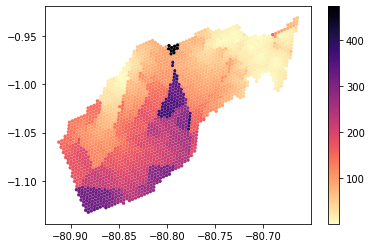

In [26]:
hex_manta_gdf_access.plot('duration_to_nearest_health_facility', cmap='magma_r', legend=True, missing_kwds={'color': 'grey'})
plt.show()

# Using Dash to create an interactive webapp

Import Dash dependencies

In [27]:
from dash import dcc, html
from dash.dependencies import Input, Output

In this example we are using JupyterDash to show our webapp within jupyter lab or a notebook.

In [28]:
from jupyter_dash import JupyterDash

In [46]:
app = JupyterDash(name='UrbanPy Dashboard')

In [47]:
VARIABLE_OPTIONS = [
    {'label': 'Duración del viaje', 'value': 'duration_to_nearest_health_facility'},
    {'label': 'Población mayor de 60', 'value': 'ecu_elderly_60_plus_2020'}
]

In [48]:
app.layout = html.Div([
    html.H3('Análisis de Acceso a Establecimientos de Salud para Población Mayor (>60 años) en Manta, Ecuador'),
    dcc.Dropdown(id='variable', value='ecu_elderly_60_plus_2020', options=VARIABLE_OPTIONS),
    dcc.Graph(id="map")
])

In [49]:
@app.callback(Output('map', 'figure'),
              [Input('variable', 'value')])
def update_map(var):
    return up.plotting.choropleth_map(gdf=hex_manta_gdf_access.query('ecu_elderly_60_plus_2020 > 0').reset_index(drop=True),
                                      color_column=var, zoom=10, opacity=0.5)

In [50]:
app.run_server(mode='inline')

Thanks for viewing this example notebook. You can find the urbanpy documentation [here](https://ingenieriaup.github.io/urbanpy/).

Useful resources:

1. [Dash Getting Started](https://dash.plotly.com/layout)
2. [Dash Make your Webapp publicly available](https://dash.plotly.com/deployment)